In [13]:
pip install findspark pandas awswrangler numpy matplotlib seaborn pyspark


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import findspark
import pandas as pd
import awswrangler as wr
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import matplotlib.ticker as ticker
import boto3
import statistics

/var/folders/x0/w5vkfm815t50y972318hw4880000gq/T/ipykernel_35592/832231458.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_result = df.groupby([
/var/folders/x0/w5vkfm815t50y972318hw4880000gq/T/ipykernel_35592/832231458.py:32: RuntimeWarning: invalid value encountered in scalar divide
  WS=("deviation", lambda x: ( (x * (1 / len(x))).sum() ) / ( (x.abs() * (1 / len(x))).sum() ) ),
/var/folders/x0/w5vkfm815t50y972318hw4880000gq/T/ipykernel_35592/832231458.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_result = df.groupby([
/var/folders/x0/w5vkfm815t50y972318hw4880000gq/T/ipykernel_35592/832231

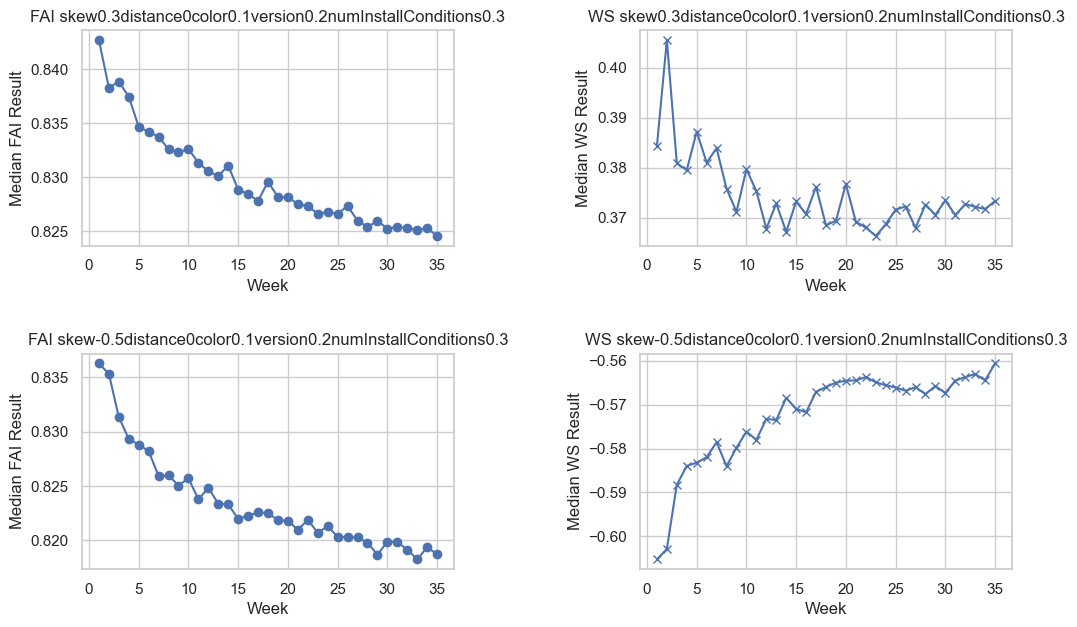

In [15]:
findspark.init()
analysis = [
    "skew0.3distance0color0.1version0.2numInstallConditions0.3",
    "skew-0.5distance0color0.1version0.2numInstallConditions0.3"
]
seaborn.set_theme(style="whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))
subplots = [ax1, ax2, ax3, ax4]
subplotidx = 0
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for dataset in analysis:
    df = pd.read_parquet(f'../../generate data/5.2/week/{dataset}/')
    df = df[~df["partCodeId"].str.contains("model")]
    df = df[df["week"] > 5]
    df["week"] = df["week"] - 5

    # I want the "deviation to be the maximum between 0 and 1 - (dfquantity - adquantity) / adquantity"
    df["deviation"] = df["dfQuantity"] - df["actualQuantity"]
    df["normalizedDeviation"] = df["deviation"].abs() / df["actualQuantity"]
    df["faiElement"] = df["normalizedDeviation"].apply(lambda x: max(0, 1 - x))

    #df.to_parquet("./bleh.parquet", index=False)

    # Group by the correct columns and calculate the final result. The final result should be the sum of ( 1/number of elements in the group * deviation)
    df_result = df.groupby([
        "partCodeId",
        "vehicleModelId",
        "week",
    ]).agg(
        FAI=("faiElement", lambda x: (x * (1 / len(x))).sum()),
        WS=("deviation", lambda x: ( (x * (1 / len(x))).sum() ) / ( (x.abs() * (1 / len(x))).sum() ) ),
        number= ("partCodeId", "count"),
    ).reset_index()

    df_result = df_result[df_result["number"] > 0 ]

    # Group by forecastdistance and calculate the median for each group
    df_week_median_FAI = df_result.groupby("week")["FAI"].median().reset_index()
    #Group by forecastdistance for WS
    df_week_median_WS = df_result.groupby("week")["WS"].median().reset_index()




    # Plot the results
    subplots[subplotidx].plot(df_week_median_FAI["week"], df_week_median_FAI["FAI"], marker='o')
    subplots[subplotidx].set_title(f"FAI {dataset}")
    subplots[subplotidx].set(xlabel="Week", ylabel="Median FAI Result")
    subplots[subplotidx].grid(True)
    subplotidx += 1

    subplots[subplotidx].plot(df_week_median_WS["week"], df_week_median_WS["WS"], marker='x')
    subplots[subplotidx].set_title(f"WS {dataset}")
    subplots[subplotidx].set(xlabel="Week", ylabel="Median WS Result")
    subplots[subplotidx].grid(True)
    subplotidx += 1

plt.show()
